# Example SN Injection and Recovery

This is an example supernova injection and recovery to use in my poster.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj
import scipy.optimize as op

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


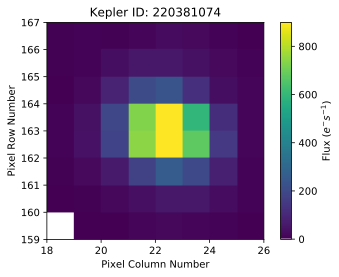

In [9]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

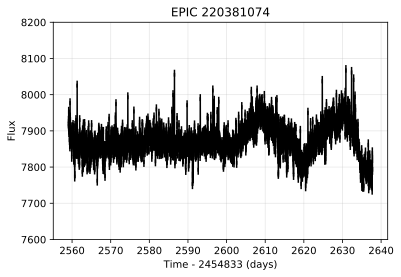

In [10]:
lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')
#plt.savefig('/Users/sheilasagear/supernovae/plots/galaxy')

In [11]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()

Text(0,0.5,'Flux')

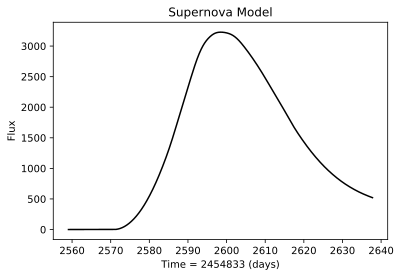

In [12]:
model_sn_eval = model.evaluate(lc.time)
plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
#plt.savefig('/Users/sheilasagear/supernovae/plots/sn_plain_model')

Text(0.5,1,'EPIC 220381074 With SN')

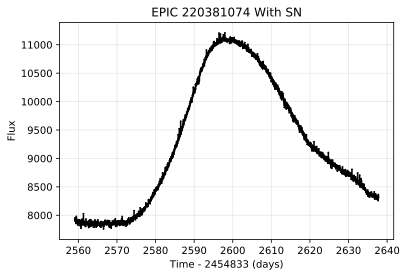

In [13]:
%config InlineBackend.figure_format = 'svg'
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')
#plt.savefig('/Users/sheilasagear/supernovae/plots/sn_injected')

In [14]:
def ln_like(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1) or (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)):
        return -1.e99
    model = SupernovaModel(T0, z=z, amplitude=amplitude, bandpass='kepler')
    model = model.evaluate(lcinj.time) + background
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood


#def neg_ln_like(theta):
#    return -1 * ln_like(theta)


In [15]:
def lnprior_optimization(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 1):
        return -1.e99
    return 0.0

In [16]:
def neg_ln_posterior(theta):
    log_posterior = lnprior_optimization(theta) + ln_like(theta)
    return -1 * log_posterior

In [18]:
%%time

#Injected values: T0=2600, z=0.5, amplitude=1e-7
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

result = op.minimize(neg_ln_posterior, x0)

CPU times: user 1min 52s, sys: 17.3 s, total: 2min 9s
Wall time: 2min 25s


In [19]:
print(result)
T0_f, z_f, amplitude_f, background_f = result["x"]

      fun: 126151.03315526394
 hess_inv: array([[  1.12417154e-05,   9.82450428e-07,  -8.25827842e-14,
         -1.84024112e-05],
       [  9.82450428e-07,   1.17508114e-07,  -8.30906019e-15,
         -1.61483554e-05],
       [ -8.25827842e-14,  -8.30906019e-15,   1.35329255e-21,
         -4.95697319e-12],
       [ -1.84024112e-05,  -1.61483554e-05,  -4.95697319e-12,
          7.36749649e-02]])
      jac: array([ -8.47163379e+03,  -2.61249854e+05,   1.47823789e+13,
         8.85276367e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 594
      nit: 8
     njev: 97
   status: 2
  success: False
        x: array([  2.59958825e+03,   4.34691906e-01,   1.90462752e-07,
         7.98950036e+03])


In [20]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

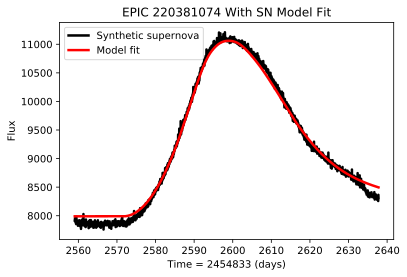

In [22]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
%config InlineBackend.figure_format = 'svg'
#plt.savefig('/Users/sheilasagear/supernovae/plots/sn_modelfit')

# Exoplanets - minimization fitting

Here I am fitting an exoplanet transit light curve using scipy.optimize.minimize - it works well for fitting supernovae so it should work for transit light curves?

In [2]:
from lightkurve.injection import TransitModel

In [3]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc_star = tpf_star.to_lightcurve(aperture_mask='all')

I am normalizing the initial lightcurve and adding another normalized lightcurve to it.

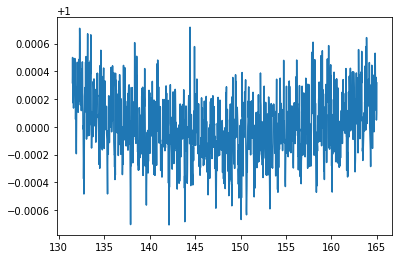

In [6]:
#Remove nans and outliers
lc_star = lc_star.remove_nans().remove_outliers()

lc_star = lc_star.normalize()
plt.plot(lc_star.time, lc_star.flux)

In [15]:
planet_model = inj.TransitModel()
planet_model.add_star()
planet_model.add_planet(5, 0.3, 133)
lc_transit = inj.inject(lc_star, planet_model)
lc_transit = lc_transit.normalize()
plt.plot(lc_transit.time, lc_transit.flux)

ImportError: dlopen(/Users/gull/anaconda3/lib/python3.6/site-packages/ktransit/_tmodtom.cpython-36m-darwin.so, 2): Symbol not found: __gfortran_internal_free
  Referenced from: /Users/gull/anaconda3/lib/python3.6/site-packages/ktransit/_tmodtom.cpython-36m-darwin.so
  Expected in: dynamic lookup


In [14]:
planet_model_eval = planet_model.evaluate(lc_star.time)
plt.plot(lc_star.time, planet_model_eval, c='k')
plt.title('Transit Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')
#plt.savefig('/Users/sheilasagear/supernovae/plots/transit_model')

NameError: name 'planet_model' is not defined

Text(0.5,1,'KIC 1867630 With Planet')

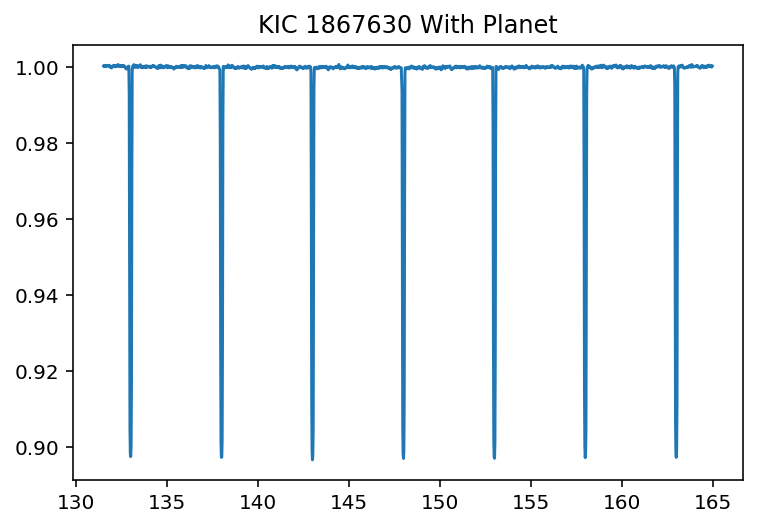

In [21]:
plt.plot(lc_transit.time, lc_transit.flux)
plt.title('KIC 1867630 With Planet')
#plt.savefig('/Users/sheilasagear/supernovae/plots/transit_injected')

In [34]:
def ln_like(theta):
    period, rprs, T0 = theta
    model = TransitModel()
    model.add_star()
    model.add_planet(period, rprs, T0)
    model_eval = model.evaluate(lc_star.time)
    plt.plot(lc_star.time, model_eval)
    plt.xlim(131,138)
    inv_sigma2 = 1.0/(lc_transit.flux_err**2)
    chisq = (np.sum((lc_transit.flux - model_eval)**2 * inv_sigma2))
    lnlikelihood = -0.5*chisq
    
    return lnlikelihood

In [35]:
def neg_ln_posterior(theta):
    return -ln_like(theta)

CPU times: user 6.95 s, sys: 75.9 ms, total: 7.02 s
Wall time: 7.08 s


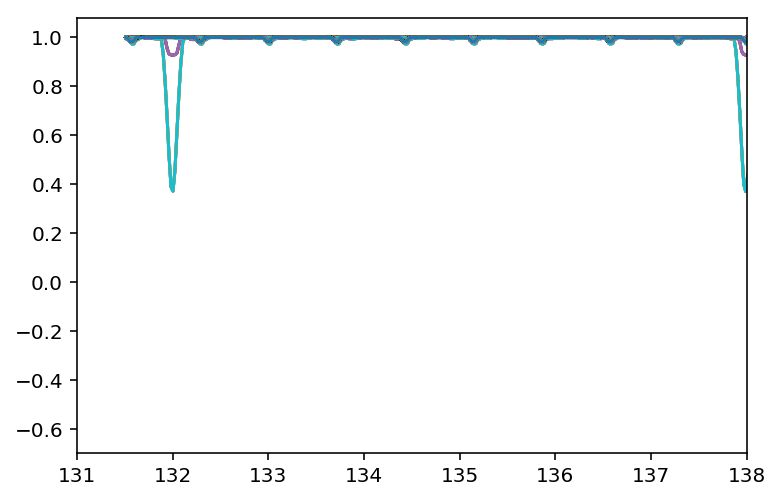

In [47]:
%%time

x0 = [6, 0.25, 132]
result = op.minimize(neg_ln_posterior, x0)


In [48]:
#planet_model.add_planet(5, 0.2, 133)
print(result)
period_f, rprs_f, T0_f = result.x

      fun: 16458960.927547444
 hess_inv: array([[ 1.46073165e-12, -2.14838554e-13, -2.29143775e-11],
       [-2.14838554e-13,  1.02928943e-09, -2.80592776e-13],
       [-2.29143775e-11, -2.80592776e-13,  6.01512918e-10]])
      jac: array([412896.5  ,  -3039.875,  34291.75 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 811
      nit: 16
     njev: 162
   status: 2
  success: False
        x: array([7.14288369e-01, 1.24504179e-01, 1.37283350e+02])


In [26]:
rprs_arr = np.linspace(0.01, 0.5, 50)

In [27]:
chisqs = rprs_arr*0.0
for i, rprs in enumerate(rprs_arr):
    chisq = neg_ln_posterior([5, rprs, 133])
    chisqs[i] = chisq

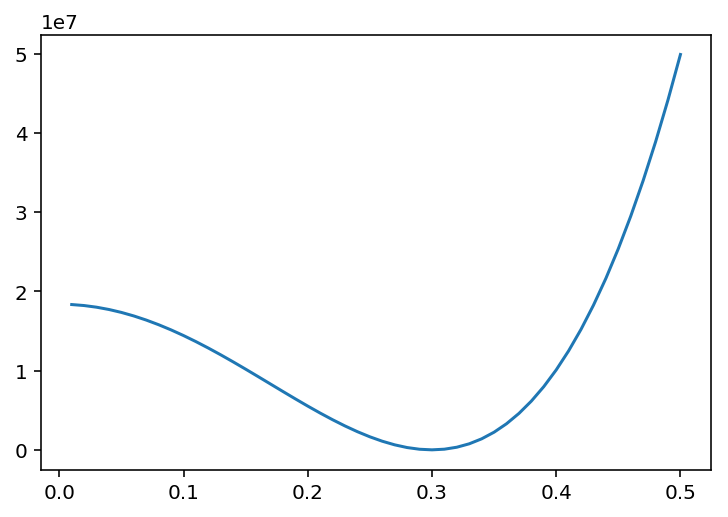

In [28]:
chisqs
plt.plot(rprs_arr, chisqs)

[ 0.          0.38461538  0.76923077  1.15384615  1.53846154  1.92307692
  2.30769231  2.69230769  3.07692308  3.46153846  3.84615385  4.23076923
  4.61538462  5.          5.38461538  5.76923077  6.15384615  6.53846154
  6.92307692  7.30769231  7.69230769  8.07692308  8.46153846  8.84615385
  9.23076923  9.61538462 10.         10.38461538 10.76923077 11.15384615
 11.53846154 11.92307692 12.30769231 12.69230769 13.07692308 13.46153846
 13.84615385 14.23076923 14.61538462 15.        ]


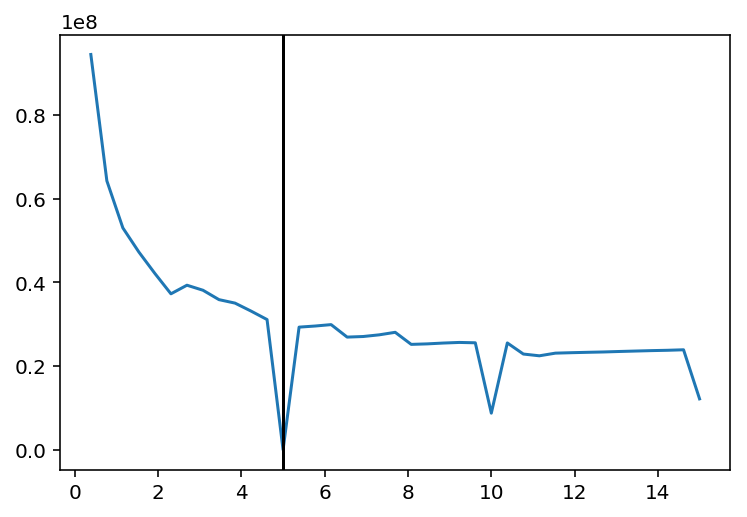

In [46]:
#add_planet(5, 0.3, 133)

per_arr = np.linspace(0, 15, 40)
print(per_arr)

chisqs = per_arr*0.0
for i, per in enumerate(per_arr):
    chisq = neg_ln_posterior([per, 0.3, 133])
    chisqs[i] = chisq

plt.cla()
plt.plot(per_arr, chisqs)
plt.axvline(5, color='k')


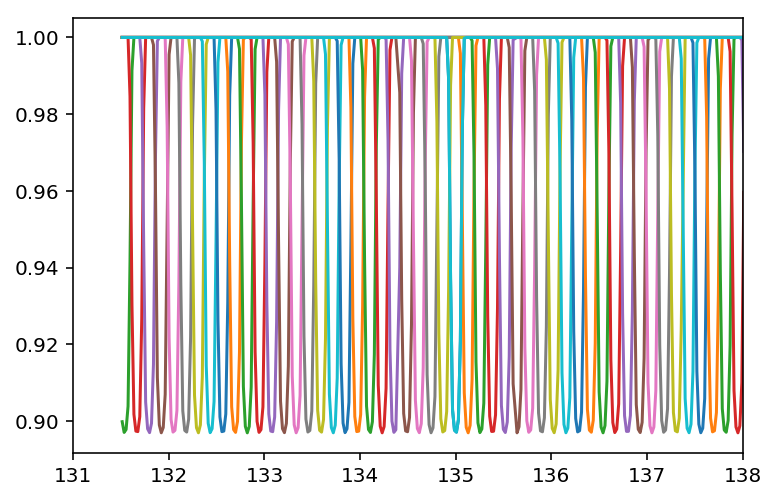

In [44]:
T0_arr = np.linspace(130, 135, 40)

chisqs = T0_arr*0.0
for i, T0 in enumerate(T0_arr):
    chisq = neg_ln_posterior([5, 0.3, T0])
    chisqs[i] = chisq

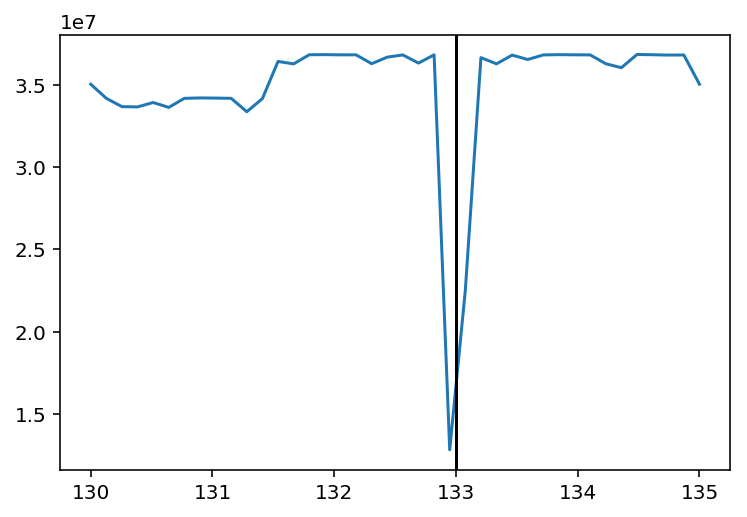

In [45]:
plt.plot(T0_arr, chisqs)
plt.axvline(133, color='k')

In [40]:
new_model = inj.TransitModel()
new_model.add_star()
new_model.add_planet(period_f, rprs_f, T0_f)
new_fit = new_model.evaluate(lc_transit.time)

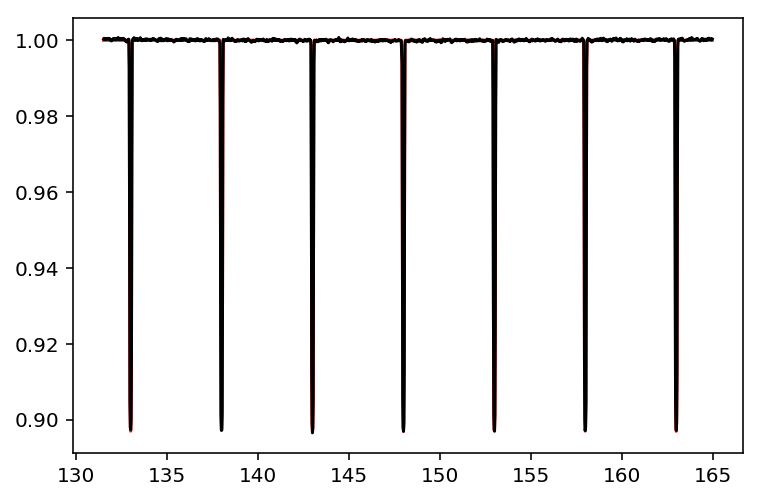

In [41]:
plt.plot(lc_transit.time, new_fit, c='r')
plt.plot(lc_transit.time, lc_transit.flux, c='k')